In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import cobra 
from cobra import Model, Reaction, Metabolite 
import pickle
from tqdm import tqdm 
from ast import literal_eval
import matplotlib.pyplot as plt
import sys
import pandas as pd
from rdkit import Chem
from rdkit.DataStructs import TanimotoSimilarity
from rdkit.DataStructs import FingerprintSimilarity
from rdkit.Chem import AllChem
from tqdm import tqdm
from Bio import SeqIO
import pandas as pd
import pickle
from collections import Counter
import json
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

### input and output

In [2]:
###input
yeast870_path =  '../../Data/model/yeast-GEM.yml'
yeast8U_path = '../../Data/model/Yeast-MetaTwin.yml'
miss_met_id_path = '../../Data/model/miss_met_id.json'

###output
ss_ssn_snsn_reaction_ratio_figure_path = '../../Results/Figures/fig2-c.pdf'
yeast8_reaction_map_ipath3_file = '../../Results/iPath3/yeast8_reaction_ipath3.csv'
yeast8_met_frequency_ipath3_file = '../../Results/iPath3/yeast8_all_metabolite_ipath3.csv'
link_met_frequency_ipath3_file = '../../Results/iPath3/yeast8U_link_metabolite_ipath3.csv'
yeast8U_met_frequency_ipath3_file = '../../Results/iPath3/yeast8U_all_metabolite_ipath3.csv'# yeast8+link

###  reaction with core/underground metabolite

In [3]:
yeast8U = cobra.io.load_yaml_model(yeast8U_path)

In [4]:
with open(miss_met_id_path, 'r') as f:
    miss_met_id = json.load(f)

In [5]:
def get_ss_ssn_snsn_reaction_ratio(yeast8U_path,miss_met_id):
    yeast8U = cobra.io.load_yaml_model(yeast8U_path)
    s_s_num = 0
    s_sn_num = 0
    sn_sn_num = 0

    for reac in tqdm(yeast8U.reactions):
        if 'rxn' in reac.id:
            met_list = [met.id for met, coe in reac.metabolites.items()]
            met_list = [x for x in met_list if x not in miss_met_id]
            # Statistical naming pattern
            if all(x.startswith('s_') for x in met_list):
                s_s_num += 1
            # elif all(x.startswith('sn_') for x in met_list) or all(x.startswith('snu_') for x in met_list):
            elif all(x.startswith('sn_') for x in met_list) or all(x.startswith('snu_') for x in met_list):
                sn_sn_num += 1
            else:
                s_sn_num += 1

    print('s_s_num',s_s_num)
    print('s_sn_num',s_sn_num)
    print('sn_sn_num',sn_sn_num)  
    return s_s_num,s_sn_num,sn_sn_num

In [6]:
def draw_ss_ssn_snsn_reaction_pie_figure(s_s_num,s_sn_num,sn_sn_num,figure_path):
    # Plot configuration
    plt.figure(figsize=(2, 2), dpi=400)
    plt.rcParams.update({'font.size': 7})
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['pdf.fonttype']= 42

    # Plotting data
    explode0 = (0.01, 0.01, 0.01)
    data = [s_s_num/(s_s_num + s_sn_num + sn_sn_num), s_sn_num/(s_s_num + s_sn_num + sn_sn_num), sn_sn_num/(s_s_num + s_sn_num + sn_sn_num)]
    print('s_s_num:',data[0])
    print('s_sn_num:',data[1])
    print('sn_sn_num:',data[2])
    plt.pie(data, 
            colors=['#999999', '#41ae76', '#f781bf'], 
            explode=explode0, 
            radius=0.7, 
            autopct=lambda p: f'{int(p * (s_s_num + s_sn_num + sn_sn_num) / 100)}', 
            textprops={'fontsize': 7})
    # Add legend
    plt.legend(["Only known metabolites", "Bridge known and underground metabolites", 'Only underground metabolites'],
            bbox_to_anchor=(1.2, 0.85), loc='lower right', fontsize=7, frameon=False, labelspacing=0.5, handletextpad=0.3)
    
#     plt.tight_layout()
    plt.savefig(figure_path, dpi=400,bbox_inches='tight')
    plt.show()

In [7]:
s_s_num,s_sn_num,sn_sn_num = get_ss_ssn_snsn_reaction_ratio(yeast8U_path,miss_met_id)

100%|██████████| 7512/7512 [00:00<00:00, 155952.80it/s]

s_s_num 1759
s_sn_num 1459
sn_sn_num 163


s_s_num: 0.5202602780242532
s_sn_num: 0.43152913339248744
sn_sn_num: 0.04821058858325939


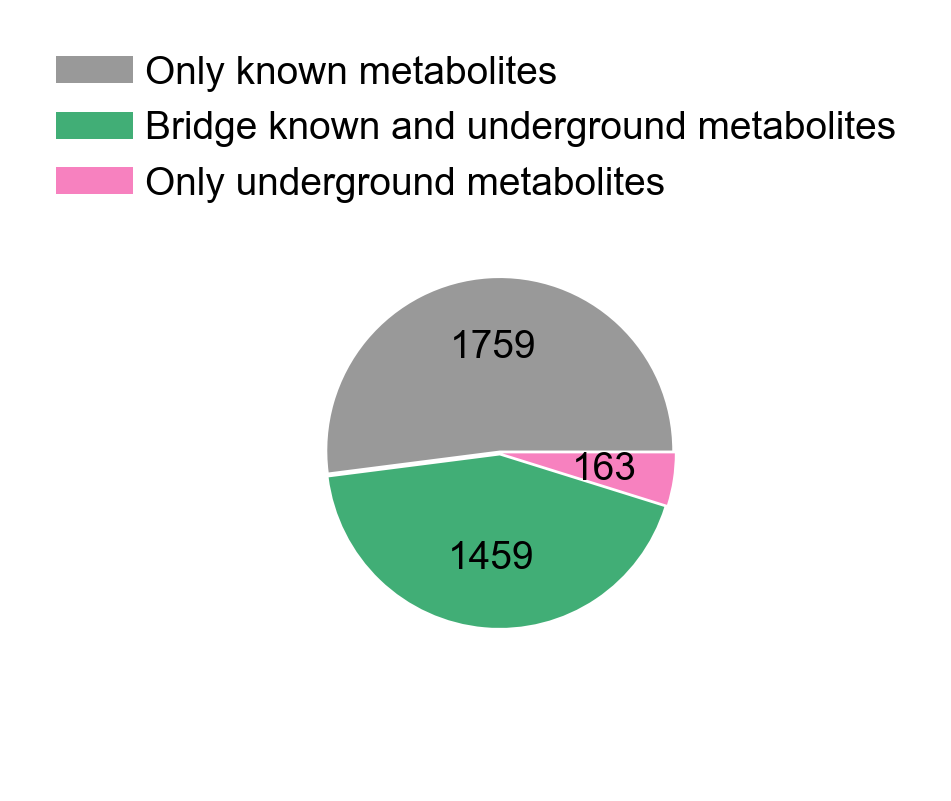

In [8]:
draw_ss_ssn_snsn_reaction_pie_figure(s_s_num,s_sn_num,sn_sn_num,ss_ssn_snsn_reaction_ratio_figure_path)

### bridge core and underground metabolites

In [9]:
def get_underground_reaction_met_id(yeast8U_path):
    yeast8U = cobra.io.load_yaml_model(yeast8U_path)
    link_met = []
    for reac in yeast8U.reactions:
        if 'rxn' in reac.id:
            # if 's_' in reac.reaction and 'sn_' in reac.reaction:
            #    print([key.id for key,value in reac.metabolites.items() if 's_' in key.id])
                link_met += [key.id for key,value in reac.metabolites.items() if 's_' in key.id]
    link_met = set(link_met)
    print('link_met',len(link_met))    
    return link_met

In [10]:
link_met_id_lst = get_underground_reaction_met_id(yeast8U_path)
link_met_id_lst

link_met 635


{'s_0007',
 's_0008',
 's_0009',
 's_0010',
 's_0012',
 's_0015',
 's_0017',
 's_0018',
 's_0019',
 's_0020',
 's_0021',
 's_0025',
 's_0030',
 's_0031',
 's_0035',
 's_0042',
 's_0048',
 's_0051',
 's_0054',
 's_0056',
 's_0061',
 's_0062',
 's_0066',
 's_0079',
 's_0086',
 's_0118',
 's_0126',
 's_0131',
 's_0132',
 's_0134',
 's_0136',
 's_0138',
 's_0140',
 's_0141',
 's_0145',
 's_0148',
 's_0149',
 's_0152',
 's_0153',
 's_0154',
 's_0161',
 's_0162',
 's_0166',
 's_0169',
 's_0174',
 's_0176',
 's_0178',
 's_0180',
 's_0185',
 's_0188',
 's_0192',
 's_0193',
 's_0195',
 's_0196',
 's_0201',
 's_0204',
 's_0207',
 's_0208',
 's_0209',
 's_0211',
 's_0212',
 's_0215',
 's_0217',
 's_0222',
 's_0224',
 's_0232',
 's_0234',
 's_0239',
 's_0247',
 's_0253',
 's_0257',
 's_0258',
 's_0260',
 's_0264',
 's_0269',
 's_0270',
 's_0271',
 's_0274',
 's_0280',
 's_0281',
 's_0282',
 's_0285',
 's_0286',
 's_0290',
 's_0291',
 's_0294',
 's_0295',
 's_0296',
 's_0297',
 's_0298',
 's_0301',

### metabolite frequency in underground reaction

In [11]:
def get_underg_reaction_met_keggid_and_frequency(yeast870_path,yeast8U_path,link_met_id_lst,link_met_frequency_ipath3_file):
    yeast8 = cobra.io.load_yaml_model(yeast870_path)
    yeast8U = cobra.io.load_yaml_model(yeast8U_path)
    link_metabolite_list = {'KEGG_id':[],
                    'color':[],
                    'frequency':[],
                    'width':[]}
    for i in link_met_id_lst:
        if 'kegg.compound' in yeast8.metabolites.get_by_id(i).annotation:
            link_metabolite_list['KEGG_id'].append(yeast8.metabolites.get_by_id(i).annotation['kegg.compound'])
            link_metabolite_list['color'].append('#d73027')
            link_metabolite_list['width'].append('W10') 
            frequency = 0
            for rea in yeast8U.reactions:
                if 'rxn' in rea.id:
                    if i in rea.reaction:
                        frequency +=1
            link_metabolite_list['frequency'].append(frequency) 
        else:pass
            # print('no kegg id',i)    
    link_met_keggid_and_frequency = pd.DataFrame(link_metabolite_list)
    # link_met_keggid_and_frequency.to_csv(link_met_frequency_ipath3_file,header=None,index=None,sep='\t')
    return link_met_keggid_and_frequency

In [12]:
underg_reaction_met_keggid_and_frequency = get_underg_reaction_met_keggid_and_frequency(yeast870_path,yeast8U_path,link_met_id_lst,link_met_frequency_ipath3_file)

In [13]:
miss_kegg_id = ['C00001','C00002','C00003','C00004','C00005','C00006','C00007','C00008','C00009','C00010',
                'C00011','C00013','C00020','C00080','C00085','C00275','C00446','C00704','C01094','C01342']

for i in miss_kegg_id:
    underg_reaction_met_keggid_and_frequency = underg_reaction_met_keggid_and_frequency[underg_reaction_met_keggid_and_frequency['KEGG_id']!= i]

underg_reaction_met_keggid_and_frequency = underg_reaction_met_keggid_and_frequency.sort_values(by='frequency', ascending=False).reset_index(drop=True)

In [14]:
underg_reaction_met_keggid_and_frequency['width'] = underg_reaction_met_keggid_and_frequency['frequency'].apply(lambda x: 'W' + str(x//30 * 5 + 20))
underg_reaction_met_keggid_and_frequency.loc[underg_reaction_met_keggid_and_frequency['width']=='W20','color'] = '#a8ddb5'#feb24c#fc9272
underg_reaction_met_keggid_and_frequency.loc[underg_reaction_met_keggid_and_frequency['width']=='W25','color'] = '#7bccc4'#fd8d3c#fb6a4a
underg_reaction_met_keggid_and_frequency.loc[underg_reaction_met_keggid_and_frequency['width']=='W30','color'] = '#4eb3d3'#fc4e2a#ef3b2c
underg_reaction_met_keggid_and_frequency.loc[underg_reaction_met_keggid_and_frequency['width']=='W35','color'] = '#2b8cbe'#e31a1c#cb181d
underg_reaction_met_keggid_and_frequency.loc[underg_reaction_met_keggid_and_frequency['width']=='W40','color'] = '#0868ac'#bd0026#a50f15
underg_reaction_met_keggid_and_frequency.loc[underg_reaction_met_keggid_and_frequency['width']=='W45','color'] = '#084081'#800026#67000d

underg_reaction_met_keggid_and_frequency.loc[underg_reaction_met_keggid_and_frequency['width']=='W50','color'] = '#084081'
underg_reaction_met_keggid_and_frequency.loc[underg_reaction_met_keggid_and_frequency['width']=='W50','width'] = 'W45'

underg_reaction_met_keggid_and_frequency.loc[underg_reaction_met_keggid_and_frequency['width']=='W55','color'] = '#084081'
underg_reaction_met_keggid_and_frequency.loc[underg_reaction_met_keggid_and_frequency['width']=='W55','width'] = 'W45'

underg_reaction_met_keggid_and_frequency.loc[underg_reaction_met_keggid_and_frequency['width']=='W60','color'] = '#084081'
underg_reaction_met_keggid_and_frequency.loc[underg_reaction_met_keggid_and_frequency['width']=='W60','width'] = 'W45'

underg_reaction_met_keggid_and_frequency.loc[underg_reaction_met_keggid_and_frequency['width']=='W65','color'] = '#084081'
underg_reaction_met_keggid_and_frequency.loc[underg_reaction_met_keggid_and_frequency['width']=='W65','width'] = 'W45'
underg_reaction_met_keggid_and_frequency

,KEGG_id,color,frequency,width
0,C00124,#0868ac,129,W40
1,C02336,#2b8cbe,98,W35
2,C00036,#2b8cbe,97,W35
3,C00022,#2b8cbe,93,W35
4,C00049,#2b8cbe,93,W35
...,...,...,...,...
483,C00062,#a8ddb5,1,W20
484,C00804,#a8ddb5,1,W20
485,C00741,#a8ddb5,1,W20
486,C00445,#a8ddb5,1,W20


In [15]:
underg_reaction_met_keggid_and_frequency[['KEGG_id','color','width']].to_csv(link_met_frequency_ipath3_file,header=None,index=None,sep='\t')

### Yeast8 reaction map

In [16]:
def get_yeast8_reaction_map_ipath3(yeast870_path):
    yeast8 = cobra.io.load_yaml_model(yeast870_path)
    reaction_list = {'KEGG_id':[],
                    'color':[],
                    'width':[]}
    for i in yeast8.reactions:
        if 'kegg.reaction' in i.annotation:
            if i.annotation['kegg.reaction'] not in reaction_list['KEGG_id']:
                reaction_list['KEGG_id'].append(i.annotation['kegg.reaction'])
                reaction_list['color'].append('#934b43')#蓝色
                reaction_list['width'].append('W2')

    for i in yeast8.metabolites:
        if 'kegg.compound' in i.annotation:
            if i.annotation['kegg.compound'] not in reaction_list['KEGG_id']:
                reaction_list['KEGG_id'].append(i.annotation['kegg.compound'])
                reaction_list['color'].append('#2171b5')#蓝色
                reaction_list['width'].append('W10')

    yeast8_reaction_map_ipath3 = pd.DataFrame(reaction_list)
    return yeast8_reaction_map_ipath3

In [17]:
yeast8_reaction_map_ipath3 = get_yeast8_reaction_map_ipath3(yeast870_path)

In [18]:
print(yeast8_reaction_map_ipath3.shape)
yeast8_reaction_map_ipath3['color'] = '#934b43'
yeast8_reaction_map_ipath3['color'] = '#EF7A6D'
yeast8_reaction_map_ipath3['width'] = 'W2'
yeast8_reaction_map_ipath3 = yeast8_reaction_map_ipath3[yeast8_reaction_map_ipath3['KEGG_id'].str.contains('R')]
# yeast8_reaction_map_ipath3 = yeast8_reaction_map_ipath3[~yeast8_reaction_map_ipath3['KEGG_id'].isin(underg_reaction_met_keggid_and_frequency['KEGG_id'].to_list())]
print(yeast8_reaction_map_ipath3.shape)

(1649, 3)
(763, 3)


In [19]:
yeast8_reaction_map_ipath3

,KEGG_id,color,width
0,R00197,#EF7A6D,W2
1,R02946,#EF7A6D,W2
2,R00196,#EF7A6D,W2
3,R03118,#EF7A6D,W2
4,R04640,#EF7A6D,W2
...,...,...,...
758,R01411,#EF7A6D,W2
759,R00434,#EF7A6D,W2
760,R12688,#EF7A6D,W2
761,R00187,#EF7A6D,W2


In [20]:
yeast8_reaction_map_ipath3.to_csv(yeast8_reaction_map_ipath3_file,header=None,index=None,sep='\t')

### metabolites frequency in Yeast8

In [21]:
def get_yeast8_reaction_met_keggid_and_frequency(yeast870_path):
    yeast8 = cobra.io.load_yaml_model(yeast870_path)
    link_metabolite_list = {'KEGG_id':[],
                    'color':[],
                    'frequency':[],
                    'width':[]}
    for i in yeast8.metabolites:
        if i.compartment!='e' and 'kegg.compound' in yeast8.metabolites.get_by_id(i.id).annotation:
            link_metabolite_list['KEGG_id'].append(yeast8.metabolites.get_by_id(i.id).annotation['kegg.compound'])
            link_metabolite_list['color'].append('#d73027')
            link_metabolite_list['width'].append('W10') 
            frequency = 0
            for rea in yeast8.reactions:
                if i.id in rea.reaction and len(rea.metabolites)>1:
                    frequency +=1
            link_metabolite_list['frequency'].append(frequency) 
        else:pass
            # print('no kegg id',i)    
    link_met_keggid_and_frequency = pd.DataFrame(link_metabolite_list)
    # link_met_keggid_and_frequency.to_csv(link_met_frequency_ipath3_file,header=None,index=None,sep='\t')
    return link_met_keggid_and_frequency

In [22]:
yeast8_reaction_met_keggid_and_frequency = get_yeast8_reaction_met_keggid_and_frequency(yeast870_path)

In [23]:
miss_kegg_id = ['C00001','C00002','C00003','C00004','C00005','C00006','C00007','C00008','C00009','C00010',
                'C00011','C00013','C00020','C00080','C00085','C00275','C00446','C00704','C01094','C01342']

for i in miss_kegg_id:
    yeast8_reaction_met_keggid_and_frequency = yeast8_reaction_met_keggid_and_frequency[yeast8_reaction_met_keggid_and_frequency['KEGG_id']!= i]

yeast8_reaction_met_keggid_and_frequency = yeast8_reaction_met_keggid_and_frequency.groupby('KEGG_id', as_index=False).agg({
    'color': 'first',
    'frequency': 'sum',
    'width': 'first'
})
yeast8_reaction_met_keggid_and_frequency = yeast8_reaction_met_keggid_and_frequency.sort_values(by='frequency', ascending=False).reset_index(drop=True)

In [24]:
yeast8_reaction_met_keggid_and_frequency

,KEGG_id,color,frequency,width
0,C00055,#d73027,92,W10
1,C03916,#d73027,76,W10
2,C00025,#d73027,76,W10
3,C04102,#d73027,76,W10
4,C00712,#d73027,73,W10
...,...,...,...,...
855,C00940,#d73027,1,W10
856,C00936,#d73027,1,W10
857,C00870,#d73027,1,W10
858,C05445,#d73027,1,W10


In [25]:
yeast8_reaction_met_keggid_and_frequency['width'] = yeast8_reaction_met_keggid_and_frequency['frequency'].apply(lambda x: 'W' + str(x//20 * 5 + 20))
# 'W' + str(x//30 * 5 + 20)
yeast8_reaction_met_keggid_and_frequency.loc[yeast8_reaction_met_keggid_and_frequency['width']=='W20','color'] = '#a8ddb5'#feb24c#fc9272
yeast8_reaction_met_keggid_and_frequency.loc[yeast8_reaction_met_keggid_and_frequency['width']=='W25','color'] = '#7bccc4'#fd8d3c#fb6a4a
yeast8_reaction_met_keggid_and_frequency.loc[yeast8_reaction_met_keggid_and_frequency['width']=='W30','color'] = '#4eb3d3'#fc4e2a#ef3b2c
yeast8_reaction_met_keggid_and_frequency.loc[yeast8_reaction_met_keggid_and_frequency['width']=='W35','color'] = '#2b8cbe'#e31a1c#cb181d
yeast8_reaction_met_keggid_and_frequency.loc[yeast8_reaction_met_keggid_and_frequency['width']=='W40','color'] = '#0868ac'#bd0026#a50f15
yeast8_reaction_met_keggid_and_frequency.loc[yeast8_reaction_met_keggid_and_frequency['width']=='W45','color'] = '#084081'#800026#67000d

yeast8_reaction_met_keggid_and_frequency.loc[yeast8_reaction_met_keggid_and_frequency['width']=='W50','color'] = '#084081'
yeast8_reaction_met_keggid_and_frequency.loc[yeast8_reaction_met_keggid_and_frequency['width']=='W50','width'] = 'W45'

yeast8_reaction_met_keggid_and_frequency.loc[yeast8_reaction_met_keggid_and_frequency['width']=='W55','color'] = '#084081'
yeast8_reaction_met_keggid_and_frequency.loc[yeast8_reaction_met_keggid_and_frequency['width']=='W55','width'] = 'W45'

yeast8_reaction_met_keggid_and_frequency.loc[yeast8_reaction_met_keggid_and_frequency['width']=='W60','color'] = '#084081'
yeast8_reaction_met_keggid_and_frequency.loc[yeast8_reaction_met_keggid_and_frequency['width']=='W60','width'] = 'W45'

yeast8_reaction_met_keggid_and_frequency.loc[yeast8_reaction_met_keggid_and_frequency['width']=='W65','color'] = '#084081'
yeast8_reaction_met_keggid_and_frequency.loc[yeast8_reaction_met_keggid_and_frequency['width']=='W65','width'] = 'W45'
yeast8_reaction_met_keggid_and_frequency

,KEGG_id,color,frequency,width
0,C00055,#0868ac,92,W40
1,C03916,#2b8cbe,76,W35
2,C00025,#2b8cbe,76,W35
3,C04102,#2b8cbe,76,W35
4,C00712,#2b8cbe,73,W35
...,...,...,...,...
855,C00940,#a8ddb5,1,W20
856,C00936,#a8ddb5,1,W20
857,C00870,#a8ddb5,1,W20
858,C05445,#a8ddb5,1,W20


In [26]:
yeast8_reaction_met_keggid_and_frequency[['KEGG_id','color','width']].to_csv(yeast8_met_frequency_ipath3_file,header=None,index=None,sep='\t')

# metabolites frequency in Yeast-MetaTwin

In [27]:
yeast8_reaction_met_keggid_and_frequency.head(2)

,KEGG_id,color,frequency,width
0,C00055,#0868ac,92,W40
1,C03916,#2b8cbe,76,W35


In [28]:
underg_reaction_met_keggid_and_frequency.head(2)

,KEGG_id,color,frequency,width
0,C00124,#0868ac,129,W40
1,C02336,#2b8cbe,98,W35


In [29]:
yeast8U_met_keggid_and_frequency = pd.concat([yeast8_reaction_met_keggid_and_frequency[['KEGG_id', 'frequency']], underg_reaction_met_keggid_and_frequency[['KEGG_id', 'frequency']]])
yeast8U_met_keggid_and_frequency = yeast8U_met_keggid_and_frequency.groupby('KEGG_id', as_index=False).sum()
yeast8U_met_keggid_and_frequency = yeast8U_met_keggid_and_frequency.sort_values(by='frequency', ascending=False).reset_index(drop=True)
yeast8U_met_keggid_and_frequency

,KEGG_id,frequency
0,C00025,147
1,C00026,138
2,C00124,134
3,C00022,132
4,C00027,129
...,...,...
858,C06325,1
859,C01861,1
860,C06112,1
861,C02170,1


In [30]:
yeast8U_met_keggid_and_frequency['width'] = yeast8U_met_keggid_and_frequency['frequency'].apply(lambda x: 'W' + str(x//30 * 5 + 20))

yeast8U_met_keggid_and_frequency.loc[yeast8U_met_keggid_and_frequency['width']=='W20','color'] = '#a8ddb5'#feb24c#fc9272
yeast8U_met_keggid_and_frequency.loc[yeast8U_met_keggid_and_frequency['width']=='W25','color'] = '#7bccc4'#fd8d3c#fb6a4a
yeast8U_met_keggid_and_frequency.loc[yeast8U_met_keggid_and_frequency['width']=='W30','color'] = '#4eb3d3'#fc4e2a#ef3b2c
yeast8U_met_keggid_and_frequency.loc[yeast8U_met_keggid_and_frequency['width']=='W35','color'] = '#2b8cbe'#e31a1c#cb181d
yeast8U_met_keggid_and_frequency.loc[yeast8U_met_keggid_and_frequency['width']=='W40','color'] = '#0868ac'#bd0026#a50f15
yeast8U_met_keggid_and_frequency.loc[yeast8U_met_keggid_and_frequency['width']=='W45','color'] = '#084081'#800026#67000d

yeast8U_met_keggid_and_frequency.loc[yeast8U_met_keggid_and_frequency['width']=='W50','color'] = '#084081'
yeast8U_met_keggid_and_frequency.loc[yeast8U_met_keggid_and_frequency['width']=='W50','width'] = 'W45'

yeast8U_met_keggid_and_frequency.loc[yeast8U_met_keggid_and_frequency['width']=='W55','color'] = '#084081'
yeast8U_met_keggid_and_frequency.loc[yeast8U_met_keggid_and_frequency['width']=='W55','width'] = 'W45'

yeast8U_met_keggid_and_frequency.loc[yeast8U_met_keggid_and_frequency['width']=='W60','color'] = '#084081'
yeast8U_met_keggid_and_frequency.loc[yeast8U_met_keggid_and_frequency['width']=='W60','width'] = 'W45'

yeast8U_met_keggid_and_frequency.loc[yeast8U_met_keggid_and_frequency['width']=='W65','color'] = '#084081'
yeast8U_met_keggid_and_frequency.loc[yeast8U_met_keggid_and_frequency['width']=='W65','width'] = 'W45'

yeast8U_met_keggid_and_frequency.loc[yeast8U_met_keggid_and_frequency['width']=='W70','color'] = '#084081'
yeast8U_met_keggid_and_frequency.loc[yeast8U_met_keggid_and_frequency['width']=='W70','width'] = 'W45'

yeast8U_met_keggid_and_frequency.loc[yeast8U_met_keggid_and_frequency['width']=='W75','color'] = '#084081'
yeast8U_met_keggid_and_frequency.loc[yeast8U_met_keggid_and_frequency['width']=='W75','width'] = 'W45'

yeast8U_met_keggid_and_frequency

,KEGG_id,frequency,width,color
0,C00025,147,W40,#0868ac
1,C00026,138,W40,#0868ac
2,C00124,134,W40,#0868ac
3,C00022,132,W40,#0868ac
4,C00027,129,W40,#0868ac
...,...,...,...,...
858,C06325,1,W20,#a8ddb5
859,C01861,1,W20,#a8ddb5
860,C06112,1,W20,#a8ddb5
861,C02170,1,W20,#a8ddb5


In [31]:
yeast8U_met_keggid_and_frequency[['KEGG_id','color','width']].to_csv(yeast8U_met_frequency_ipath3_file,header=None,index=None,sep='\t')